In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

foldername = '/content/drive/My Drive/github/trans/transformer-glucose/'
assert foldername is not None, "[!] Enter the foldername."

# add path to .py code
import sys
sys.path.append(foldername)

In [ ]:
%%capture
!pip install pytorch-lightning==1.4.9
!pip install pytorch-forecasting
!pip install pandas --upgrade

In [1]:
import numpy as np
import pandas as pd
import os
import pickle

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [2]:
foldername = '/home/mrsergazinov/python-git-workspace/gluformer/'

path = foldername + 'gludata/data'
with open(path+"/train_data_pyforecast.pkl", 'rb') as f:
      train_data_raw = pickle.load(f)
with open(path+"/val_data_pyforecast.pkl", 'rb') as f:
      val_data_raw = pickle.load(f)

In [3]:
def read_data(data):
  data_pd = pd.DataFrame(columns = ["id", "segment", "timeidx", "CGM", "dayofyear", "dayofmonth", "dayofweek", "hour", "minute", "date"])
  for i in range(len(data)):
    temp = pd.DataFrame()
    temp["id"] = [data[i][0]] * len(data[i][1]) 
    temp["segment"] = [str(i)] * len(data[i][1]) 
    temp["timeidx"] = len(data_pd) + np.arange(1, len(data[i][1]) + 1)
    temp["CGM"] = data[i][1].flatten() 
    temp[["dayofyear", "dayofmonth", "dayofweek", "hour", "minute"]] = data[i][2]
    temp["date"] = data[i][3]
    data_pd = data_pd.append(temp)
  data_pd["timeidx"] = data_pd["timeidx"].astype(int)
  data_pd["id"] = data_pd["id"].astype(str).astype("category")
  data_pd["segment"] = data_pd["segment"].astype(str).astype("category")
  data_pd = data_pd.reset_index()
  data_pd = data_pd.drop(columns=["index"])
  return data_pd

train_data_pd = read_data(train_data_raw)
val_data_pd = read_data(val_data_raw)

In [4]:
train_data = TimeSeriesDataSet(
    train_data_pd,
    time_idx="timeidx",
    target="CGM",
    group_ids=["id", "segment"],
    max_encoder_length=180,
    max_prediction_length=12,
    static_categoricals=["id", "segment"],
    time_varying_known_reals=["timeidx", 
                              "dayofyear", 
                              "dayofmonth", 
                              "dayofweek", 
                              "hour", 
                              "minute"],
    target_normalizer=None,
)
train_dataloader = train_data.to_dataloader(train=True, batch_size=32, num_workers=24)


val_data = TimeSeriesDataSet(
    val_data_pd,
    time_idx="timeidx",
    target="CGM",
    group_ids=["id", "segment"],
    max_encoder_length=180,
    max_prediction_length=12,
    static_categoricals=["id", "segment"],
    time_varying_known_reals=["timeidx", 
                              "dayofyear", 
                              "dayofmonth", 
                              "dayofweek", 
                              "hour", 
                              "minute"],
    target_normalizer=None,
)
val_dataloader = val_data.to_dataloader(train=False, batch_size=32, num_workers=24)

In [5]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    weights_summary="top",
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    train_data,
    learning_rate=0.0001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 2561.4k


In [6]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

/home/mrsergazinov/anaconda3/envs/torch/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:530: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 25.4 K
3  | prescalers                         | ModuleDict                      | 1.9 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 1.1 K 
5  | encoder_variable_selection         | VariableSelectionNe

Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [7]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [10]:
trainer.save_checkpoint(os.getcwd()+'/tft.ckpt')

In [6]:
best_tft = tft.load_from_checkpoint(os.getcwd()+'/tft.ckpt')

In [7]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(2.2224, dtype=torch.float64)

In [8]:
val_dataloader = val_data.to_dataloader(train=False, batch_size=32, num_workers=0)
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

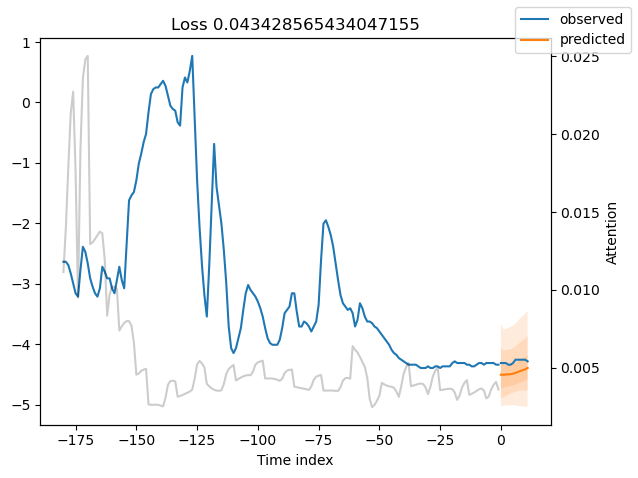

In [9]:
best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)

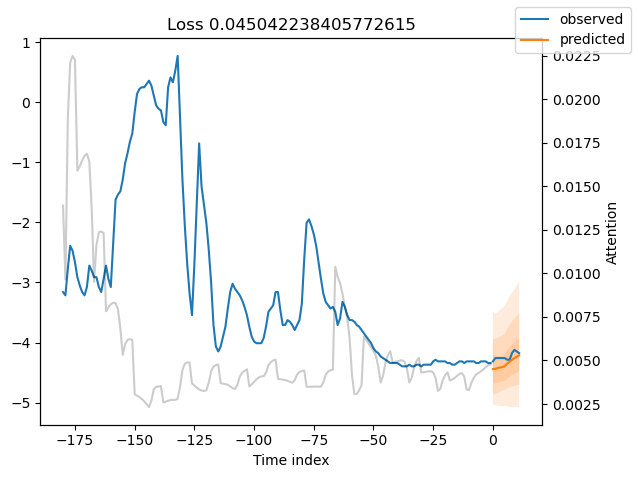

In [10]:
best_tft.plot_prediction(x, raw_predictions, idx=5, add_loss_to_title=True)

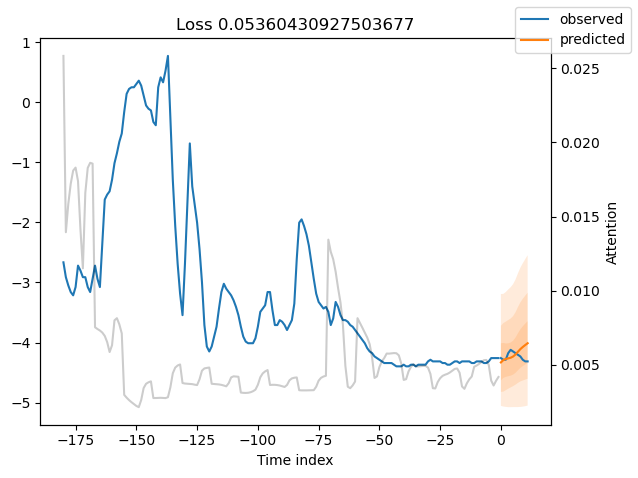

In [11]:
best_tft.plot_prediction(x, raw_predictions, idx=10, add_loss_to_title=True)

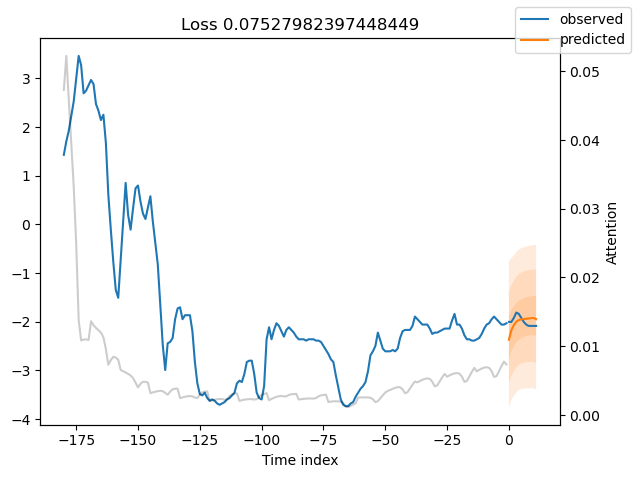

In [12]:
best_tft.plot_prediction(x, raw_predictions, idx=300, add_loss_to_title=True)

In [14]:
actuals.shape

torch.Size([14283, 12])

In [15]:
out = [y for x, y in iter(val_dataloader)]

In [26]:
type(out[0][1])

NoneType